In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

In [2]:
#function from lab 3
def imshow(images, titles, nrows = 0, ncols=0, figsize = (15,20)):
    """Plot a multiple images with titles.
    Parameters
    ----------
    images : image list
    titles : title list
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    if ncols == 0 and nrows == 0:
      ncols = len(images)
      nrows = 1
    if ncols == 0:
      ncols = len(images) // nrows
    if nrows == 0:
      nrows = len(images) // ncols
      
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, squeeze=False, figsize = figsize)
    for i, image in enumerate(images):
        axeslist.ravel()[i].imshow(image, cmap=plt.gray(), vmin=0, vmax=255)
        axeslist.ravel()[i].set_title(titles[i])
        axeslist.ravel()[i].set_axis_off()
    plt.tight_layout() 

In [3]:
video_path = "sample.mp4"

cap = cv2.VideoCapture(video_path)   #open our sample
original_codec = int(cap.get(cv2.CAP_PROP_FOURCC))    #the format of our sample
images = []     #images of our sample
if not cap.isOpened():
    print("Impossible d'ouvrir la vidéo.")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        _, img_png = cv2.imencode(".png", frame)
        images.append(cv2.imdecode(np.frombuffer(img_png, np.uint8), cv2.IMREAD_COLOR))
    cap.release()

In [4]:
def create_video(images, output_path, fps=25):   #creation of the video from the images
    height, width, _ = images[0].shape
    fourcc = original_codec    #to have the same format than the sample
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for img in images:
        out.write(img)
    out.release()

The first approach involves applying filters to our images.

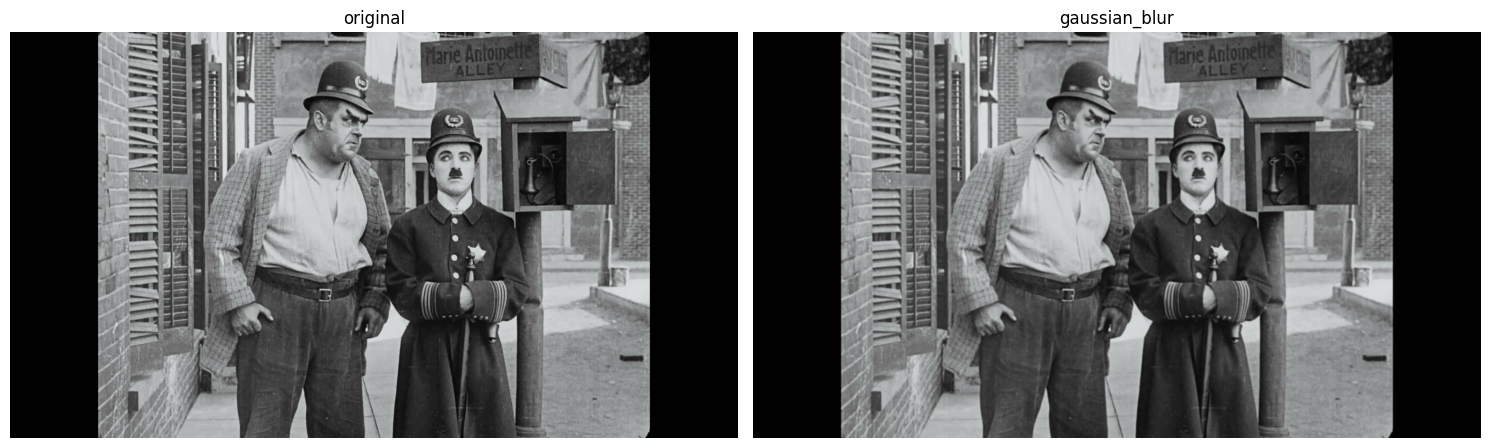

In [5]:
images_gaussian_blur = []     #images of the video with gaussian blur

for image in images:
    images_gaussian_blur.append(cv2.GaussianBlur(image, (5, 5), 0))

imshow([images[0], images_gaussian_blur[0]], ["original", "gaussian_blur"])

output_video_path = "video_gaussian_blur.mp4"
create_video(images_gaussian_blur, output_video_path)

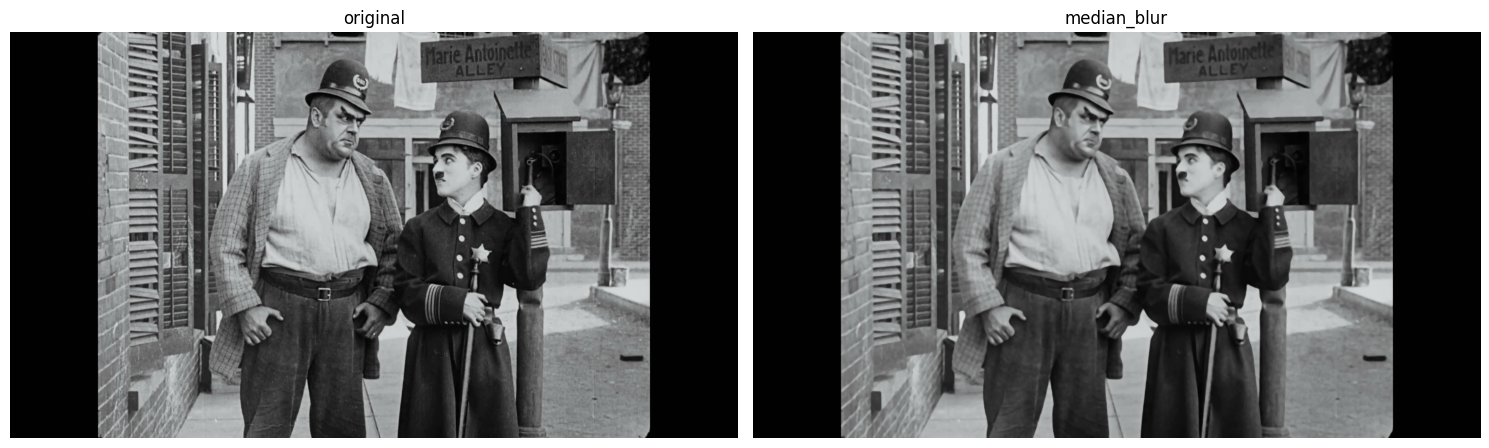

In [6]:
images_median_blur = []      #images of the video with median blur

for image in images:
    images_median_blur.append(cv2.medianBlur(image, 7))

imshow([images[100], images_median_blur[100]], ["original", "median_blur"])

output_video_path = "video_median_blur.mp4"
create_video(images_median_blur, output_video_path)

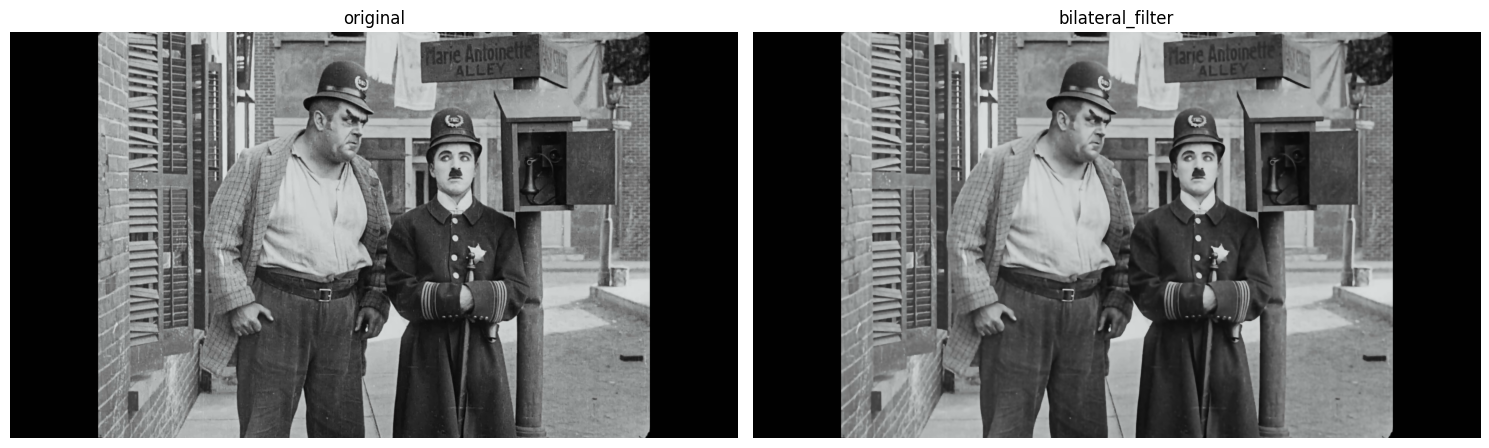

In [7]:
images_bilateral_filter = []      #images of the video with bilateral filter

for image in images:
    images_bilateral_filter.append(cv2.bilateralFilter(image, d=7, sigmaColor=75, sigmaSpace=75))

imshow([images[0], images_bilateral_filter[0]], ["original", "bilateral_filter"])

output_video_path = "video_bilateral_filter.mp4"
create_video(images_bilateral_filter, output_video_path)

The result from the filter are insufficient. The second idea is to capture the noise to learn how to eliminate it.

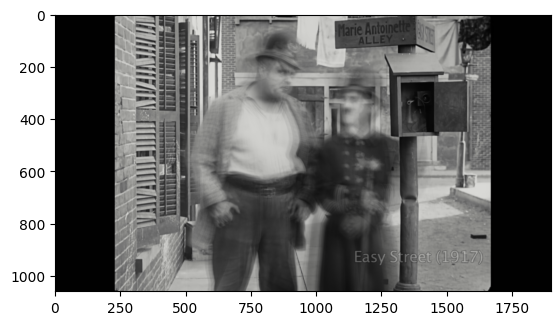

In [8]:
def extraction(images, x1, x2, y1, y2):     #extract the pixels beetwen x1, x2 and y1, y2 from all the images
    images_extraites = []
    for i in range(len(images)):
        images_extraites.append(images[i][y1:y2, x1:x2])
    return images_extraites

def mean_images(images):         #create an average image from all the images 
    img_shape = images[0].shape
    img_mean = np.zeros(img_shape, dtype=np.float32)
    for image in images:
        img_mean += image
    img_mean /= len(images)
    return img_mean.astype(np.uint8)

plt.imshow(cv2.cvtColor(mean_images(images), cv2.COLOR_BGR2RGB))

In [9]:
moyenne = mean_images(images)      #the average image of all frames
images_fixed = []                  #we fixed the background with the average image : denoising of the background
for i in range(len(images)): 
    image_fixed = images[i].copy()
    image_fixed[0:1100, 1350:1750] = moyenne[0:1100, 1350:1750]
    image_fixed[0:1100, 0:500] = moyenne[0:1100, 0:500]
    images_fixed.append(image_fixed)

output_video_path = "video_background_fixed.mp4"
create_video(images_fixed, output_video_path)

In [10]:
def difference_images_and_average(images, average_image):    #make the differences beetwenn all the images and the average image
    diff_images = [cv2.absdiff(image, average_image) for image in images]
    return diff_images

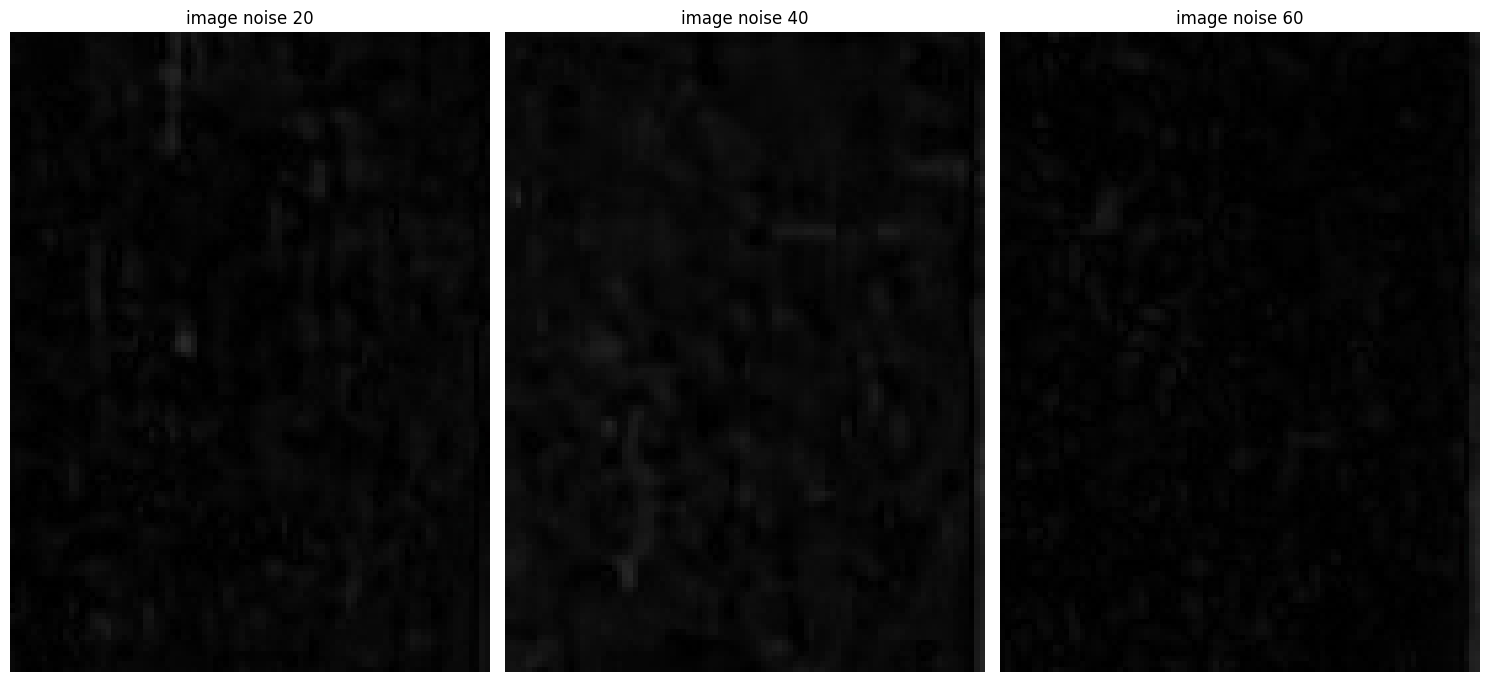

In [11]:
images_door = extraction(images,1490,1580,270,390)      #We capture the noise on the door because it is a background part that is homogeneous in color.
average_door = mean_images(images_door)                 
images_noise = difference_images_and_average(images_door, average_door)   #the differences beetween the frames and the average image on the door is the noise

imshow([images_noise[20], images_noise[40], images_noise[60]], ["image noise 20", "image noise 40", "image noise 60"])

In [12]:
video_paths = ["video_training_1.mp4", "video_training_2.mp4", "video_training_3.mp4"]    #We downloaded three black-and-white videos but any video can be utilized.

images_training = []      #contains all the frames of each video
for video_path in video_paths:
    cap = cv2.VideoCapture(video_path)
    original_codec = int(cap.get(cv2.CAP_PROP_FOURCC))
    if not cap.isOpened():
        print("Impossible d'ouvrir la vidéo.")
    else:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            _, img_png = cv2.imencode(".png", frame)
            images_training.append(cv2.imdecode(np.frombuffer(img_png, np.uint8), cv2.IMREAD_COLOR))
        cap.release()

In [20]:
images_training_noise = []       #we added the noise to the training (in reality just the middle of the videos)
i = 0
for image in images_training:
    images_training_noise.append(image.copy())
    images_training_noise[i][0:120, 210:300] = cv2.add(image[0:120, 210:300], images_noise[i%274])
    images_training_noise[i][120:240, 210:300] = cv2.add(image[120:240, 210:300], images_noise[(i+60)%274])
    images_training_noise[i][0:120, 300:390] = cv2.add(image[0:120, 300:390], images_noise[(i+120)%274])
    images_training_noise[i][120:240, 300:390] = cv2.add(image[120:240, 300:390], images_noise[(i+180)%274])
    i += 1

In [21]:
output_video_path = "video_training_noise.mp4"         
create_video(images_training_noise, output_video_path)

In [22]:
X = []       #contains the input of the model    (the noisy images)
Y = []       #contains the theorical output of the model     (the denoised image)
for i in range(len(images_training)):
    X.append(images_training_noise[i][0:179, 210:389])   
    Y.append(images_training[i][0:179, 210:389])

X = np.array(X)
Y = np.array(Y)
X_cut = X[0:5000]    #Our computers are not powerful enough to train our model on all the data.
Y_cut = Y[0:5000]

In [23]:
tensor_X = torch.from_numpy(X_cut).float() / 255     #transformation in tensor
tensor_Y = torch.from_numpy(Y_cut).float() / 255

dataset = TensorDataset(tensor_X, tensor_Y)

In [24]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)        #our dataset with noisy and denoised images

In [25]:
class AutorEncoder(nn.Module):       #our model inspired by the article of Y.Zhang 
    def __init__(self):
        super(AutorEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = (3,3), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size = (3,3), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size = (3,3), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size = (3,3), stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size = (3,3), stride = 2, padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 2, padding = 0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size = (3,3), stride = 1, padding = 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
model = AutorEncoder()
summary(model, (3, 179, 179))   #The challenge with autoencoders is to achieve the same dimensionality in both input and output.

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 179, 179]             896
              ReLU-2         [-1, 32, 179, 179]               0
         MaxPool2d-3           [-1, 32, 89, 89]               0
            Conv2d-4           [-1, 64, 89, 89]          18,496
              ReLU-5           [-1, 64, 89, 89]               0
         MaxPool2d-6           [-1, 64, 44, 44]               0
            Conv2d-7          [-1, 128, 44, 44]          73,856
              ReLU-8          [-1, 128, 44, 44]               0
         MaxPool2d-9          [-1, 128, 22, 22]               0
  ConvTranspose2d-10          [-1, 128, 45, 45]         147,584
             ReLU-11          [-1, 128, 45, 45]               0
  ConvTranspose2d-12           [-1, 64, 89, 89]          73,792
             ReLU-13           [-1, 64, 89, 89]               0
  ConvTranspose2d-14         [-1, 32, 1

In [26]:
model = AutorEncoder()
criterion = nn.MSELoss()      #classical criterion for conventional autoencoder
optimizer = optim.Adam(model.parameters(), lr=0.0001)
losses = []

In [27]:
#classical training function
num_epochs = 10
for epoch in range(num_epochs):  
    for x, y in dataloader:
        optimizer.zero_grad()
        output = model(x.permute(0, 3, 1, 2))     #it is important to put the three chanels dimension in the beggining of our images
        y = y.permute(0,3,1,2)                    
        loss = criterion(output, y)
        losses.append(loss)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0279
Epoch [2/10], Loss: 0.0062
Epoch [3/10], Loss: 0.0039
Epoch [4/10], Loss: 0.0029
Epoch [5/10], Loss: 0.0038


: 

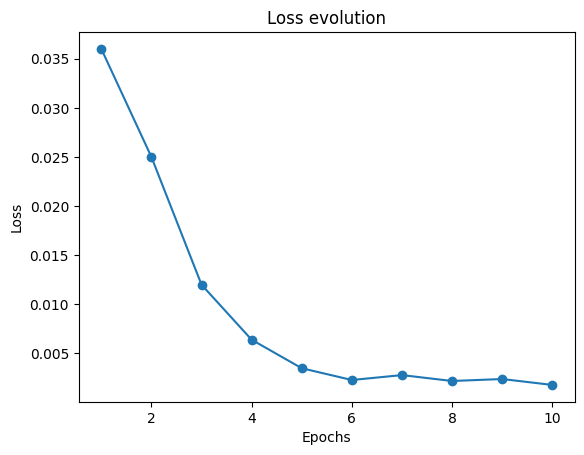

In [2]:
#the loss function -> our model learns well
epochs = range(1, len(losses) + 1)

plt.plot(epochs, losses, marker='o', linestyle='-')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

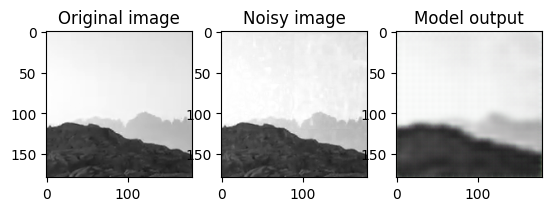

In [ ]:
#show the result on the 1400th image of our training
j = 1400
noise = tensor_X[j].permute(2, 0, 1).unsqueeze(0)
output = model(noise).squeeze(0).permute(1, 2, 0)  ##it is important to put the three chanels dimension in the beggining of our images

original_image = tensor_Y[j].detach().numpy() 
noise_image = tensor_X[j].detach().numpy() 
result_image = output.detach().numpy()

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(noise_image)
plt.title('Noisy image')


plt.subplot(1, 3, 3)
plt.imshow(result_image)
plt.title('Model output')

plt.show()